## Analyzing trajectory set 3

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import shapely as shp
import hvplot.pandas 
import matplotlib.pyplot as plt
from utils import *
from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime, timedelta
from holoviews import opts, dim
from os.path import exists
from urllib.request import urlretrieve
import seaborn as sns
from hausdorff import hausdorff_distance
from scipy.spatial.distance import directed_hausdorff
from sklearn.cluster import DBSCAN
import hdbscan
from kneed import *
import warnings
from geopy.distance import great_circle
from shapely.geometry import Point, LineString, Polygon, MultiPoint
from dtw import *
from haversine import *
from sklearn.neighbors import NearestNeighbors
import panel as pn
from sdtw import SoftDTW
warnings.filterwarnings('ignore')

plot_defaults = {'linewidth':5, 'capstyle':'round', 'figsize':(10,5), 'legend':True}
opts.defaults(opts.Overlay(active_tools=['wheel_zoom'], frame_width=800, frame_height=500))
hvplot_defaults = {'tiles':None, 'cmap':'Viridis', 'colorbar':True}
# os.environ['GDAL_DATA'] = r'/slurm/home/yrd/luolab/zhaoliang/.conda/envs/py310/Library\share\gdal'

from sklearn import metrics
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from cartopy.io.img_tiles import OSM
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
df = pd.read_csv('intersection_2021_72.csv')
df = df[df["LLI NO"].str.contains("10526246") == False]
df = df[df["LLI NO"].str.contains("1725971") == False]


In [3]:
# define the boundary
df_traj = df[df['Lng'] > -11]
df_traj = df_traj[df_traj['Lng'] < 5]
df_traj = df_traj[df_traj['Lat'] < 52.2]
df_traj = df_traj[df_traj['Lat'] > 35.5]

df_traj = df_traj[~((df_traj['Lng']>-5.5) & (df_traj['Lat']<43.5))]

# df_traj = df_traj.drop('10526246_0', axis=0)
# Gibraltar Strait
area_of_gs = Polygon([(-6.1, 35.8), (-5,  35.8), (-5, 36.2), (-6.1, 36.2)]) 
area_of_nl = Polygon([(2.0, 51.2), (4.10631,  51.2), (4.10631, 52.5), (2.0, 52.5)])

gdf = gpd.GeoDataFrame(df_traj, geometry=gpd.points_from_xy(df_traj.Lng, df_traj.Lat))

traj_collection = mpd.TrajectoryCollection(gdf, 'LLI NO', t='t', crs="EPSG:4326 WGS84")

traj = find_intersection(traj_collection, area_of_gs, area_of_nl)

print(f"Found {len(traj)} trajectories between Gibraltar Strait and Rotterdam")
df_traje_all = traj.to_traj_gdf()



Found 511 trajectories
Found 511 trajectories between Gibraltar Strait and Rotterdam


<Axes: xlabel='company'>

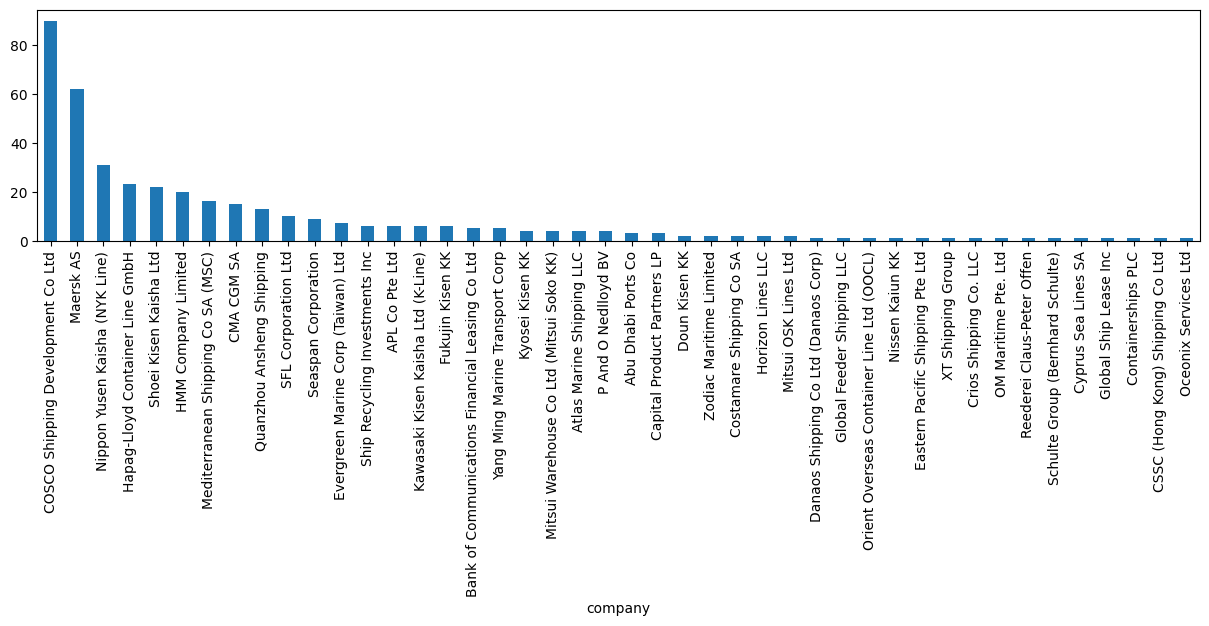

In [64]:
df_traje_all['IMO'] = np.nan

df1=pd.read_csv('container.csv')
df1['LLINO'] = df1['LLINO'].astype(str)
LLIstring = df1['LLINO']

IMOstring = df1['IMO']

for i in range(0, LLIstring.shape[0]):
    id = df_traje_all[df_traje_all['LLI NO'].str.contains(LLIstring[i], na=False)].index
    if (id.empty):
        continue
    else:
        for j in range(0, id.shape[0]):
            # df_traj[id[j], 'IMO'] = IMOstring[j]
            df_traje_all.loc[id[j], 'IMO'] = IMOstring[i]

df_traje_all['flag'] = np.nan
df_traje_all['company'] = np.nan
df_traje_all['IMO'] = df_traje_all['IMO'].astype(str)

df_IMO_company = pd.read_csv('info.csv')

IMOString = df_IMO_company['IMO'].astype(str)

for i in range(0, IMOString.shape[0]):
    id = df_traje_all[df_traje_all['IMO'].str.contains(IMOString[i], na=False)].index
    if (id.empty):
        continue
    else:
        for j in range(0, id.shape[0]):
            # df_traj[id[j], 'IMO'] = IMOstring[j]
            df_traje_all.loc[id[j], 'flag'] = df_IMO_company.loc[i, 'Flag']
            df_traje_all.loc[id[j], 'company'] = df_IMO_company.loc[i, 'Company']


df_traje_all = df_traje_all.drop(df_traje_all[df_traje_all['company'] == 'no record'].index)
df_traje_all['company'].value_counts().plot(kind='bar', figsize=(15,3))

In [8]:
df_traje_all['company'].value_counts()

company
COSCO Shipping Development Co Ltd                  90
Maersk AS                                          63
Nippon Yusen Kaisha (NYK Line)                     31
Hapag-Lloyd Container Line GmbH                    23
Shoei Kisen Kaisha Ltd                             22
HMM Company Limited                                20
Mediterranean Shipping Co SA (MSC)                 16
CMA CGM SA                                         15
Quanzhou Ansheng Shipping                          13
SFL Corporation Ltd                                10
Seaspan Corporation                                 9
Evergreen Marine Corp (Taiwan) Ltd                  7
Ship Recycling Investments Inc                      6
APL Co Pte Ltd                                      6
Kawasaki Kisen Kaisha Ltd (K-Line)                  6
Fukujin Kisen KK                                    6
Bank of Communications Financial Leasing Co Ltd     5
Yang Ming Marine Transport Corp                     5
Kyosei Kisen KK     

In [109]:
# from GS to Rotterdam
traj_list_gs2nl = [traje for traje in traj if traje.get_start_location().intersects(area_of_gs)]
traj_list_nl2gs = [traje for traje in traj if traje.get_start_location().intersects(area_of_nl)]
traj_collection_gs2nl = mpd.TrajectoryCollection(traj_list_gs2nl)
traj_collection_nl2gs = mpd.TrajectoryCollection(traj_list_nl2gs)
print(f"Found {len(traj_list_gs2nl)} trajectories from Gibraltar Strait to Rotterdam")
print(f"Found {len(traj_list_nl2gs)} trajectories from Rotterdam to Gibraltar Strait")
df_traje = traj_collection_gs2nl.to_traj_gdf()
df_traje_reverse = traj_collection_nl2gs.to_traj_gdf()

Found 271 trajectories from Gibraltar Strait to Rotterdam
Found 240 trajectories from Rotterdam to Gibraltar Strait


In [79]:
df_traje['IMO'] = np.nan

df1=pd.read_csv('container.csv')
df1['LLINO'] = df1['LLINO'].astype(str)
LLIstring = df1['LLINO']

IMOstring = df1['IMO']

for i in range(0, LLIstring.shape[0]):
    id = df_traje[df_traje['LLI NO'].str.contains(LLIstring[i], na=False)].index
    if (id.empty):
        continue
    else:
        for j in range(0, id.shape[0]):
            # df_traj[id[j], 'IMO'] = IMOstring[j]
            df_traje.loc[id[j], 'IMO'] = IMOstring[i]

df_traje['flag'] = np.nan
df_traje['company'] = np.nan
df_traje['IMO'] = df_traje['IMO'].astype(str)

df_IMO_company = pd.read_csv('info.csv')

IMOString = df_IMO_company['IMO'].astype(str)

for i in range(0, IMOString.shape[0]):
    id = df_traje[df_traje['IMO'].str.contains(IMOString[i], na=False)].index
    if (id.empty):
        continue
    else:
        for j in range(0, id.shape[0]):
            # df_traj[id[j], 'IMO'] = IMOstring[j]
            df_traje.loc[id[j], 'flag'] = df_IMO_company.loc[i, 'Flag']
            df_traje.loc[id[j], 'company'] = df_IMO_company.loc[i, 'Company']


In [80]:
df_flag = df_traje
df_flag = df_flag.drop(df_flag[df_flag['company'] == 'no record'].index)

df_flag_1 = df_flag[df_flag['company'] == 'COSCO Shipping Development Co Ltd']
df_flag_2 = df_flag[df_flag['company'] == 'Maersk AS']

df_flag_3 = df_flag[df_flag['company'] == 'Nippon Yusen Kaisha (NYK Line)']
df_flag_4 = df_flag[df_flag['company'] == 'Hapag-Lloyd Container Line GmbH']
# traj_flag_1 = mpd.Trajectory(df_flag_1, 'LLI NO')
df_flag_1.hvplot(title='COSCO', geo=True, hover_cols=['weight'], line_width=1, color='r', tiles='EsriNatGeo', frame_height=800, frame_width=500) +\
df_flag_2.hvplot(title='Maersk AS', geo=True, hover_cols=['weight'], line_width=1, color='r', tiles='EsriNatGeo', frame_height=800, frame_width=500)

:Layout
   .Overlay.I  :Overlay
      .WMTS.I :WMTS   [Longitude,Latitude]
      .Path.I :Path   [Longitude,Latitude]
   .Overlay.II :Overlay
      .WMTS.I :WMTS   [Longitude,Latitude]
      .Path.I :Path   [Longitude,Latitude]

In [81]:
df_flag_3.hvplot(title='Nippon Yusen Kaisha (NYK Line)', geo=True, hover_cols=['weight'], line_width=1, color='r', tiles='EsriNatGeo', frame_height=800, frame_width=500) +\
df_flag_4.hvplot(title='Hapag-Lloyd Container Line GmbH', geo=True, hover_cols=['weight'], line_width=1, color='r', tiles='EsriNatGeo', frame_height=800, frame_width=500)

:Layout
   .Overlay.I  :Overlay
      .WMTS.I :WMTS   [Longitude,Latitude]
      .Path.I :Path   [Longitude,Latitude]
   .Overlay.II :Overlay
      .WMTS.I :WMTS   [Longitude,Latitude]
      .Path.I :Path   [Longitude,Latitude]

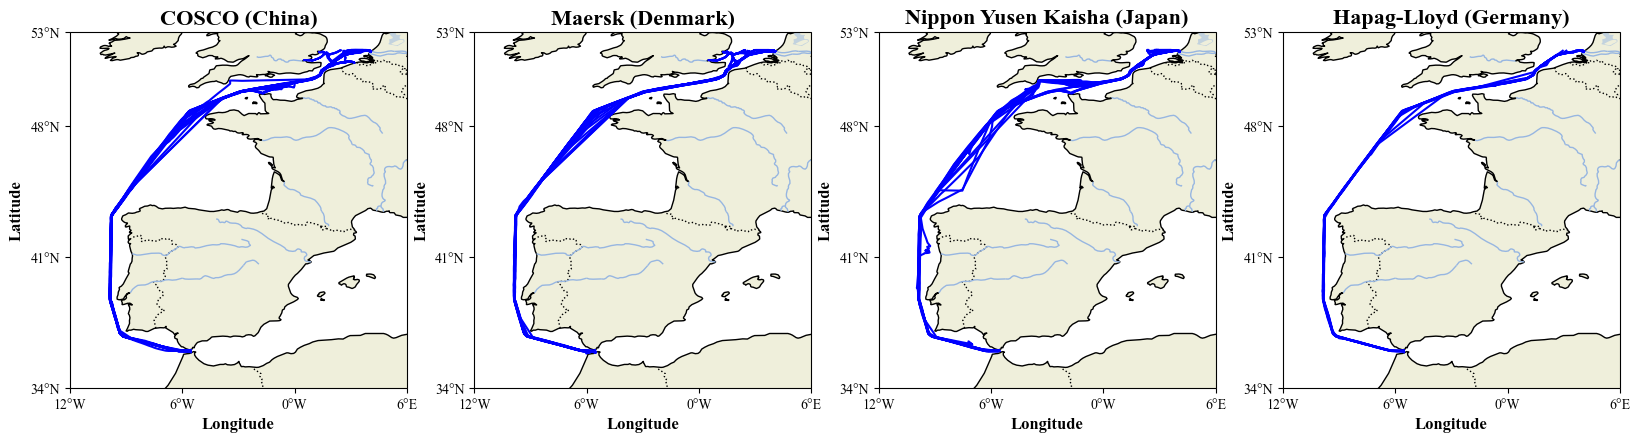

In [82]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1, 4, 1, projection=ccrs.PlateCarree())
ax = df_flag_1.plot(ax = ax, color="blue")
ax.set_extent([-12, 6, 34, 53], crs=ccrs.PlateCarree())
ax.set_xticks([-12, -6, 0, 6], crs=ccrs.PlateCarree())
ax.set_yticks([34, 41, 48, 53], crs=ccrs.PlateCarree())
# ax.stock_img()
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)


fontlabel = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }
fonttitle = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }


lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
plt.title('COSCO (China)', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)


ax = fig.add_subplot(1, 4, 2, projection=ccrs.PlateCarree())
ax = df_flag_2.plot(ax = ax, color="blue")
ax.set_extent([-12, 6, 34, 53], crs=ccrs.PlateCarree())
ax.set_xticks([-12, -6, 0, 6], crs=ccrs.PlateCarree())
ax.set_yticks([34, 41, 48, 53], crs=ccrs.PlateCarree())

SOURCE = 'Natural Earth'
LICENSE = 'public domain'
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]


plt.title('Maersk (Denmark)', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)


ax = fig.add_subplot(1, 4, 3, projection=ccrs.PlateCarree())
ax = df_flag_3.plot(ax = ax, color="blue")
ax.set_extent([-12, 6, 34, 53], crs=ccrs.PlateCarree())
ax.set_xticks([-12, -6, 0, 6], crs=ccrs.PlateCarree())
ax.set_yticks([34, 41, 48, 53], crs=ccrs.PlateCarree())

SOURCE = 'Natural Earth'
LICENSE = 'public domain'
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]


plt.title('Nippon Yusen Kaisha (Japan)', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)


ax = fig.add_subplot(1, 4, 4, projection=ccrs.PlateCarree())
ax = df_flag_4.plot(ax = ax, color="blue")
ax.set_extent([-12, 6, 34, 53], crs=ccrs.PlateCarree())
ax.set_xticks([-12, -6, 0, 6], crs=ccrs.PlateCarree())
ax.set_yticks([34, 41, 48, 53], crs=ccrs.PlateCarree())
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]


plt.title('Hapag-Lloyd (Germany)', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)

fig.savefig('company gs2rt.png', dpi=600)
plt.show()

In [83]:
df_traje_reverse['IMO'] = np.nan

df1=pd.read_csv('container.csv')
df1['LLINO'] = df1['LLINO'].astype(str)
LLIstring = df1['LLINO']

IMOstring = df1['IMO']

for i in range(0, LLIstring.shape[0]):
    id = df_traje_reverse[df_traje_reverse['LLI NO'].str.contains(LLIstring[i], na=False)].index
    if (id.empty):
        continue
    else:
        for j in range(0, id.shape[0]):
            # df_traj[id[j], 'IMO'] = IMOstring[j]
            df_traje_reverse.loc[id[j], 'IMO'] = IMOstring[i]

df_traje_reverse['flag'] = np.nan
df_traje_reverse['company'] = np.nan
df_traje_reverse['IMO'] = df_traje_reverse['IMO'].astype(str)

df_IMO_company = pd.read_csv('info.csv')

IMOString = df_IMO_company['IMO'].astype(str)

for i in range(0, IMOString.shape[0]):
    id = df_traje_reverse[df_traje_reverse['IMO'].str.contains(IMOString[i], na=False)].index
    if (id.empty):
        continue
    else:
        for j in range(0, id.shape[0]):
            # df_traj[id[j], 'IMO'] = IMOstring[j]
            df_traje_reverse.loc[id[j], 'flag'] = df_IMO_company.loc[i, 'Flag']
            df_traje_reverse.loc[id[j], 'company'] = df_IMO_company.loc[i, 'Company']

In [84]:
df_flag = df_traje_reverse
df_flag = df_flag.drop(df_flag[df_flag['company'] == 'no record'].index)

df_flag_1 = df_flag[df_flag['company'] == 'COSCO Shipping Development Co Ltd']
df_flag_2 = df_flag[df_flag['company'] == 'Maersk AS']

df_flag_3 = df_flag[df_flag['company'] == 'Nippon Yusen Kaisha (NYK Line)']
df_flag_4 = df_flag[df_flag['company'] == 'Hapag-Lloyd Container Line GmbH']

df_flag_1.hvplot(title='COSCO', geo=True, hover_cols=['weight'], line_width=1, color='r', tiles='EsriNatGeo', frame_height=500, frame_width=400) +\
df_flag_2.hvplot(title='Maersk AS', geo=True, hover_cols=['weight'], line_width=1, color='r', tiles='EsriNatGeo', frame_height=500, frame_width=400)

:Layout
   .Overlay.I  :Overlay
      .WMTS.I :WMTS   [Longitude,Latitude]
      .Path.I :Path   [Longitude,Latitude]
   .Overlay.II :Overlay
      .WMTS.I :WMTS   [Longitude,Latitude]
      .Path.I :Path   [Longitude,Latitude]

In [85]:
df_flag_3.hvplot(title='Nippon Yusen Kaisha (NYK Line)', geo=True, hover_cols=['weight'], line_width=1, color='r', tiles='EsriNatGeo', frame_height=800, frame_width=500) +\
df_flag_4.hvplot(title='Hapag-Lloyd Container Line GmbH', geo=True, hover_cols=['weight'], line_width=1, color='r', tiles='EsriNatGeo', frame_height=800, frame_width=500)

:Layout
   .Overlay.I  :Overlay
      .WMTS.I :WMTS   [Longitude,Latitude]
      .Path.I :Path   [Longitude,Latitude]
   .Overlay.II :Overlay
      .WMTS.I :WMTS   [Longitude,Latitude]
      .Path.I :Path   [Longitude,Latitude]

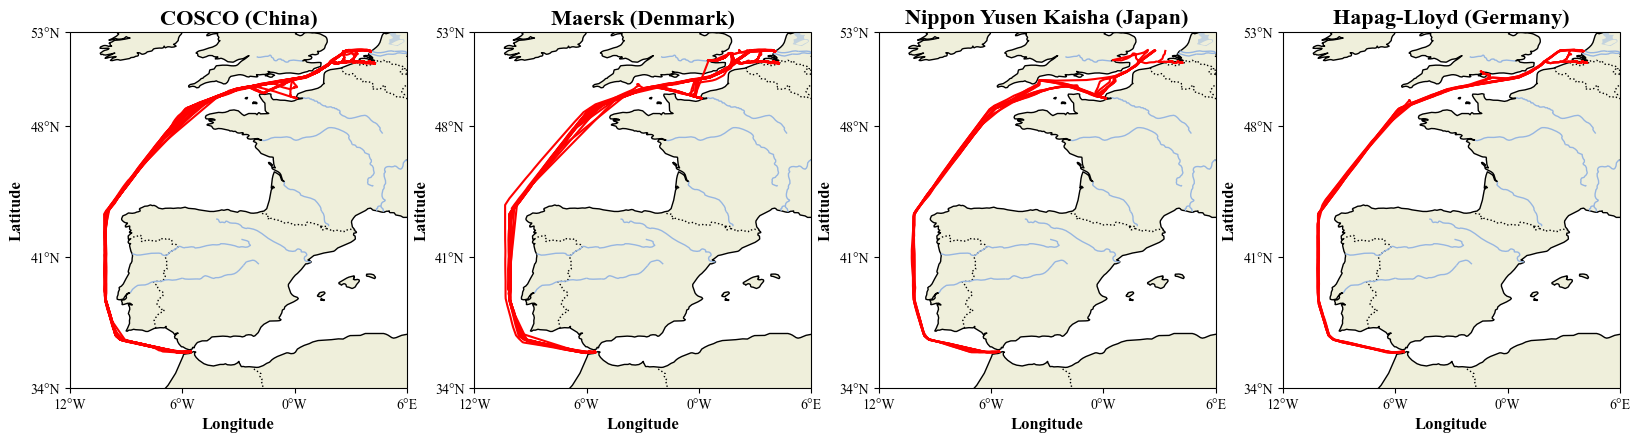

In [86]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1, 4, 1, projection=ccrs.PlateCarree())
ax = df_flag_1.plot(ax = ax, color="r")
ax.set_extent([-12, 6, 34, 53], crs=ccrs.PlateCarree())
ax.set_xticks([-12, -6, 0, 6], crs=ccrs.PlateCarree())
ax.set_yticks([34, 41, 48, 53], crs=ccrs.PlateCarree())
# ax.stock_img()
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)


fontlabel = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }
fonttitle = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }


lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
plt.title('COSCO (China)', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)


ax = fig.add_subplot(1, 4, 2, projection=ccrs.PlateCarree())
ax = df_flag_2.plot(ax = ax, color="r")
ax.set_extent([-12, 6, 34, 53], crs=ccrs.PlateCarree())
ax.set_xticks([-12, -6, 0, 6], crs=ccrs.PlateCarree())
ax.set_yticks([34, 41, 48, 53], crs=ccrs.PlateCarree())

SOURCE = 'Natural Earth'
LICENSE = 'public domain'
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]


plt.title('Maersk (Denmark)', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)


ax = fig.add_subplot(1, 4, 3, projection=ccrs.PlateCarree())
ax = df_flag_3.plot(ax = ax, color="r")
ax.set_extent([-12, 6, 34, 53], crs=ccrs.PlateCarree())
ax.set_xticks([-12, -6, 0, 6], crs=ccrs.PlateCarree())
ax.set_yticks([34, 41, 48, 53], crs=ccrs.PlateCarree())

SOURCE = 'Natural Earth'
LICENSE = 'public domain'
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]


plt.title('Nippon Yusen Kaisha (Japan)', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)


ax = fig.add_subplot(1, 4, 4, projection=ccrs.PlateCarree())
ax = df_flag_4.plot(ax = ax, color="r")
ax.set_extent([-12, 6, 34, 53], crs=ccrs.PlateCarree())
ax.set_xticks([-12, -6, 0, 6], crs=ccrs.PlateCarree())
ax.set_yticks([34, 41, 48, 53], crs=ccrs.PlateCarree())
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]


plt.title('Hapag-Lloyd (Germany)', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)

fig.savefig('company rt2gs.png', dpi=600)
plt.show()

In [110]:
# from GS to Rotterdam
traj_list_gs2nl = [traje for traje in traj if traje.get_start_location().intersects(area_of_gs)]
traj_list_nl2gs = [traje for traje in traj if traje.get_start_location().intersects(area_of_nl)]

print(f"Found {len(traj_list_gs2nl)} trajectories from Gibraltar Strait to Rotterdam")
print(f"Found {len(traj_list_nl2gs)} trajectories from Rotterdam to Gibraltar Strait")

Found 271 trajectories from Gibraltar Strait to Rotterdam
Found 240 trajectories from Rotterdam to Gibraltar Strait


### IHDBSCAN

In [155]:
# similarity measurements using softDTW
traj_collection_gs2nl = mpd.TrajectoryCollection(traj_list_gs2nl)
traj_collection_gs2nl_DP = STcompression(traj_collection_gs2nl, 0.1)
gdf_gs2nl_DP = traj_collection_gs2nl_DP.to_traj_gdf()
traj_list = df2list(gdf_gs2nl_DP)
traj_count = len(traj_list)
D = np.zeros((traj_count, traj_count))
# This may take a while
for i in range(traj_count):
    for j in range(i + 1, traj_count):
        D_single = haversine_vector_dist(traj_list[i], traj_list[j])
        sdtw = SoftDTW(D_single, gamma=0.01) 
        # distance1 = dtw(traj_list[i], traj_list[j], dist_method = haversine_dist, distance_only=True)
        D[i, j] = distance1.distance
        D[j, i] = distance1.distance


eps = find_eps(3, D)

Generating 271 trajectories in array form
The best eps value is 535.0310871621884


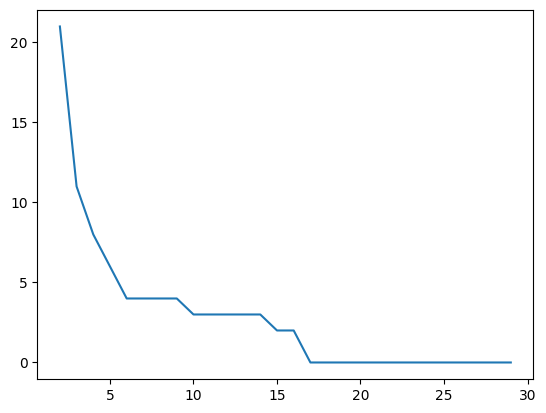

In [156]:
cluster_set = []
size_num = []
score = []
max_score = -1
for i in range(2, 30):
    size_num.append(i)
    dbscan = hdbscan.HDBSCAN(min_cluster_size =i, gen_min_span_tree=True, cluster_selection_epsilon =1000)
    cluster_lst = dbscan.fit(D)
    n_cluster = np.max(dbscan.labels_) + 1
    cluster_set.append(n_cluster)
    # if metrics.silhouette_score(D, dbscan.labels_, metric="precomputed") > max_score:
    #     best_eps = eps_set[i-2]
    #     best_cluster_size = i
    #     best_score = metrics.silhouette_score(D, dbscan.labels_, metric="precomputed")
    #     max_score =  metrics.silhouette_score(D, dbscan.labels_, metric="precomputed")
    # score.append(metrics.silhouette_score(D, dbscan.labels_, metric="precomputed"))
    
# print(best_cluster_size, best_eps, best_score)
plt.plot(size_num, cluster_set)

In [157]:
dbscan = hdbscan.HDBSCAN(min_samples=2,min_cluster_size =15, gen_min_span_tree=True, cluster_selection_epsilon =eps)
cluster_lst = dbscan.fit(D)
print(f"Trajectories are grouped into {np.max(dbscan.labels_) + 1} clusters")
print(f'DBI (0 means best): {metrics.davies_bouldin_score(D, dbscan.labels_):.3f}') 
print(f'SS (1 means better): {metrics.silhouette_score(D, dbscan.labels_):.3f}') 
print(f'Calinski-Harbasz Score (Larger means better): {metrics.calinski_harabasz_score(D, dbscan.labels_):.3f}') 

label = list(dbscan.labels_)

for i in range(0, np.max(dbscan.labels_) + 1):
    print(label.count(i))

Trajectories are grouped into 4 clusters
DBI (0 means best): 1.180
SS (1 means better): 0.173
Calinski-Harbasz Score (Larger means better): 49.430
28
20
91
20


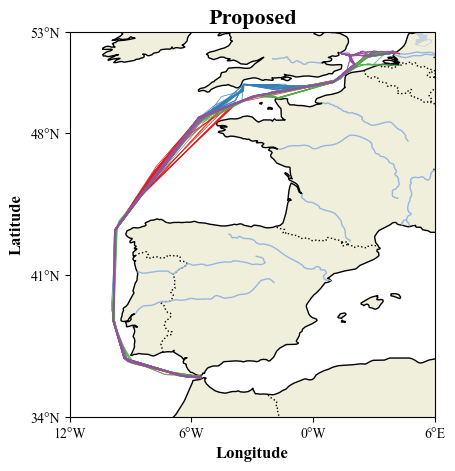

In [158]:
cluster_lst = dbscan.labels_
fig = plt.figure(figsize=(5,5))
colormp=plt.get_cmap('Set1')(range(5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
for k in range(max(dbscan.labels_)+1):
    ind = [x for x, y in list(enumerate(cluster_lst)) if y == k]
    traj_list = []
    for i in range(len(ind)):
        traj_list.append(traj_collection_gs2nl_DP.trajectories[ind[i]])
    traj_set = mpd.TrajectoryCollection(traj_list)
    ax = traj_set.plot(ax = ax, color=colormp[k], linewidth =  0.5)

ax.set_extent([-12, 6, 34, 53], crs=ccrs.PlateCarree())
ax.set_xticks([-12, -6, 0, 6], crs=ccrs.PlateCarree())
ax.set_yticks([34, 41, 48, 53], crs=ccrs.PlateCarree())
# ax.stock_img()
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
# ax.add_image(imagery)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

fontlabel = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }
fonttitle = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }


lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
plt.title('Proposed', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)

fig.savefig('tempfigs/set_3_IHDBSCAN.png', dpi=600)

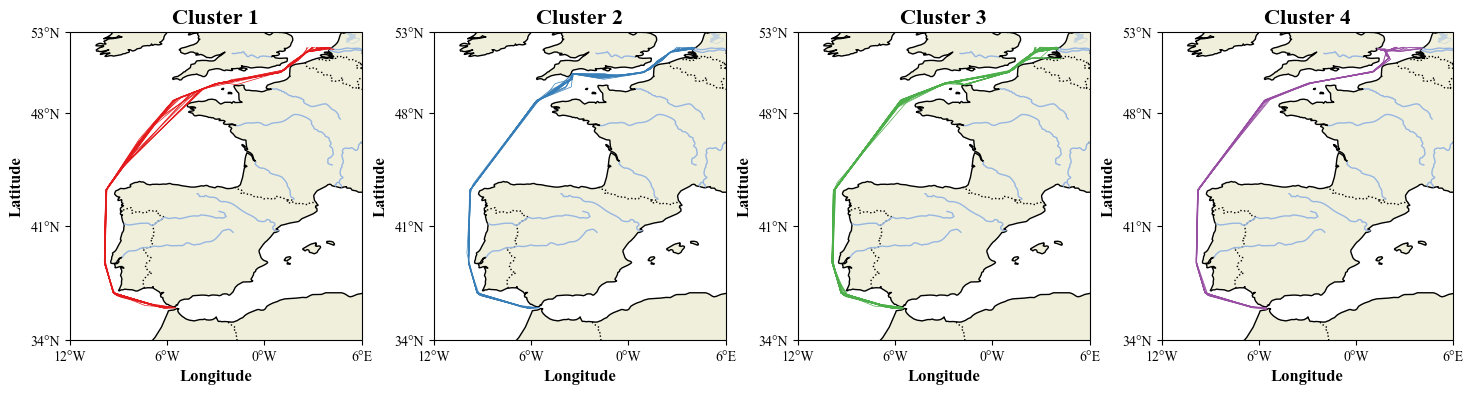

In [159]:
cluster_lst = dbscan.labels_
fig = plt.figure(figsize=(18,4))
colormp=plt.get_cmap('Set1')(range(5))
for k in range(max(dbscan.labels_)+1):
    ind = [x for x, y in list(enumerate(cluster_lst)) if y == k]
    traj_list = []
    for i in range(len(ind)):
        traj_list.append(traj_collection_gs2nl_DP.trajectories[ind[i]])
    traj_set = mpd.TrajectoryCollection(traj_list)
    ax = fig.add_subplot(1, 4, k+1, projection=ccrs.PlateCarree())
    ax = traj_set.plot(ax = ax, color=colormp[k], linewidth =  0.5)
    ax.set_extent([-12, 6, 34, 53], crs=ccrs.PlateCarree())
    # ax.stock_img()
    states_provinces = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale='50m',
            facecolor='none')
    SOURCE = 'Natural Earth'
    LICENSE = 'public domain'
    # ax.add_image(imagery)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(states_provinces, edgecolor='gray')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)

    fontlabel = {'family': 'times new roman',
            'color':  'black',
            'weight': 'bold',
            'size': 12,
            }
    fonttitle = {'family': 'times new roman',
            'color':  'black',
            'weight': 'bold',
            'size': 16,
            }

    ax.set_xticks([-12, -6, 0, 6], crs=ccrs.PlateCarree())
    ax.set_yticks([34, 41, 48, 53], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    x1_label = ax.get_xticklabels() 
    [x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
    y1_label = ax.get_yticklabels() 
    [y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
    plt.title('Cluster %d' % (k+1), fontdict=fonttitle)
    plt.xlabel('Longitude', fontdict=fontlabel)
    plt.ylabel('Latitude', fontdict=fontlabel)

    fig.savefig('tempfigs/cluster_set_3_IHDBSCAN.png', dpi=600)

### HDBSCAN

In [116]:
traj_collection_gs2nl_DP = STcompression(traj_collection_gs2nl, 0.3)
gdf_gs2nl_DP = traj_collection_gs2nl_DP.to_traj_gdf()

traj_list = df2list(gdf_gs2nl_DP)
traj_count = len(traj_list)
D_h = np.zeros((traj_count, traj_count))

# This may take a while
for i in range(traj_count):
    for j in range(i + 1, traj_count):
        distance1 = hausdorff_distance(traj_list[i], traj_list[j], distance='haversine')
        D_h[i, j] = distance1
        D_h[j, i] = distance1

eps = find_eps(3, D_h)

Generating 271 trajectories in array form
The best eps value is 86.52362491120758


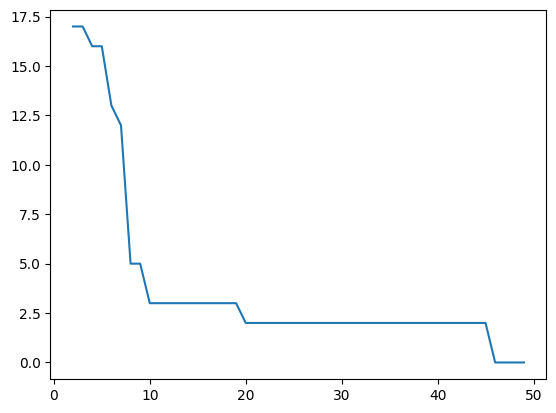

In [117]:
cluster_set = []
size_num = []
for i in range(2, 50):
    size_num.append(i)
    dbscan = hdbscan.HDBSCAN(min_samples=3, min_cluster_size =i, gen_min_span_tree=True, cluster_selection_epsilon =eps)
    cluster_lst = dbscan.fit(D_h)
    n_cluster = np.max(dbscan.labels_) + 1
    cluster_set.append(n_cluster)
    

plt.plot(size_num, cluster_set)

In [119]:
dbscan = hdbscan.HDBSCAN(min_samples=3, min_cluster_size =7,cluster_selection_epsilon =eps)
cluster_lst = dbscan.fit(D_h)
print(f"Trajectories are grouped into {np.max(dbscan.labels_) + 1} clusters")
print(f'DBI (0 means best): {metrics.davies_bouldin_score(D_h, dbscan.labels_):.3f}') 
print(f'SS (1 means better): {metrics.silhouette_score(D_h, dbscan.labels_):.3f}') 
print(f'Calinski-Harbasz Score (Larger means better): {metrics.calinski_harabasz_score(D_h, dbscan.labels_):.3f}') 

for i in range(0, np.max(dbscan.labels_) + 1):
    print(label.count(i))

Trajectories are grouped into 12 clusters
DBI (0 means best): 1.452
SS (1 means better): 0.099
Calinski-Harbasz Score (Larger means better): 27.843
28
20
91
20
0
0
0
0
0
0
0
0


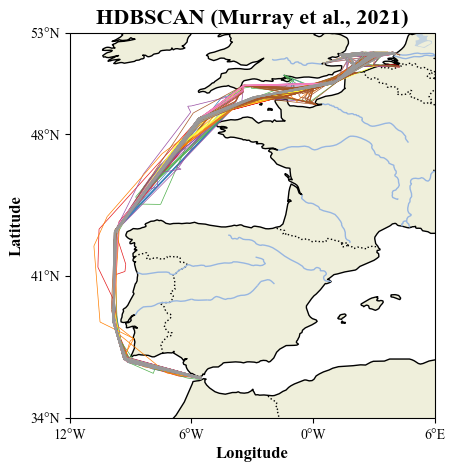

In [121]:
cluster_lst = dbscan.labels_
fig = plt.figure(figsize=(5,5))
colormp=plt.get_cmap('Set1')(range(13))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
for k in range(max(dbscan.labels_)+1):
    ind = [x for x, y in list(enumerate(cluster_lst)) if y == k]
    traj_list = []
    for i in range(len(ind)):
        traj_list.append(traj_collection_gs2nl_DP.trajectories[ind[i]])
    traj_set = mpd.TrajectoryCollection(traj_list)
    ax = traj_set.plot(ax = ax, color=colormp[k], linewidth =  0.5)

ax.set_extent([-12, 6, 34, 53], crs=ccrs.PlateCarree())
ax.set_xticks([-12, -6, 0, 6], crs=ccrs.PlateCarree())
ax.set_yticks([34, 41, 48, 53], crs=ccrs.PlateCarree())
# ax.stock_img()
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
# ax.add_image(imagery)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

fontlabel = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }
fonttitle = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }


lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
plt.title('HDBSCAN (Murray et al., 2021)', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)

fig.savefig('tempfigs/set_3_HDBSCAN.png', dpi=600)

### DBTCAN

In [122]:
traj_collection_gs2nl_DP = STcompression(traj_collection_gs2nl, 0.1)
gdf_gs2nl_DP = traj_collection_gs2nl_DP.to_traj_gdf()

traj_list = df2list(gdf_gs2nl_DP)
traj_count = len(traj_list)
D_h = np.zeros((traj_count, traj_count))
# This may take a while
for i in range(traj_count):
    for j in range(i + 1, traj_count):
        distance1 = hausdorff_distance(traj_list[i], traj_list[j], distance='haversine')
        D_h[i, j] = distance1
        D_h[j, i] = distance1
eps_set = []
for i in range(2, 20):
    eps_set.append(find_eps(i, D_h))



Generating 271 trajectories in array form
The best eps value is 138.37998698416908
The best eps value is 141.14320161137772
The best eps value is 160.86486411920185
The best eps value is 172.2524738419223
The best eps value is 183.76667792709713
The best eps value is 185.05356530183005
The best eps value is 194.17957470048276
The best eps value is 195.0891473810483
The best eps value is 200.67413270005878
The best eps value is 205.8377346473751
The best eps value is 213.7006004595882
The best eps value is 214.62539090478236
The best eps value is 222.98328711993318
The best eps value is 226.58955546080486
The best eps value is 224.57918412448672
The best eps value is 227.63883459903928
The best eps value is 227.84641536960714
The best eps value is 228.41371632514708


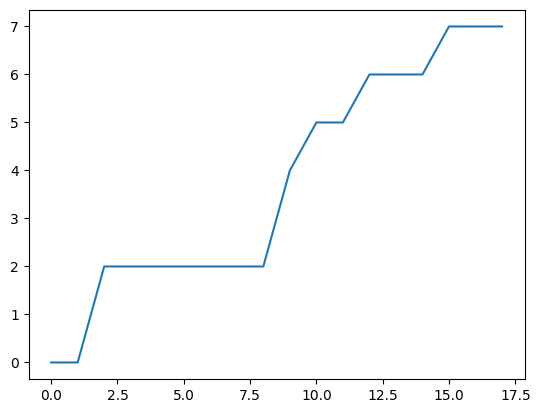

In [123]:
cluster_set = []
size_num = []
for i in range(0, len(eps_set)):
    size_num.append(i)
    mdl = DBSCAN(eps=eps_set[i], min_samples=4)
    cluster_lst = mdl.fit_predict(D_h)
    n_cluster = np.max(cluster_lst) + 1
    cluster_set.append(n_cluster)
    

plt.plot(size_num, cluster_set)

In [124]:
mdl = DBSCAN(eps=eps_set[13], min_samples=4)
cluster_lst = mdl.fit_predict(D_h)
print(f"Trajectories are grouped into {np.max(cluster_lst) + 1} clusters")
print(f'DBI (0 means best): {metrics.davies_bouldin_score(D_h, cluster_lst):.3f}') 
print(f'SS (1 means better): {metrics.silhouette_score(D_h, cluster_lst):.3f}') 
print(f'Calinski-Harbasz Score (Larger means better): {metrics.calinski_harabasz_score(D_h, cluster_lst):.3f}') 

Trajectories are grouped into 6 clusters
DBI (0 means best): 1.202
SS (1 means better): -0.248
Calinski-Harbasz Score (Larger means better): 17.257


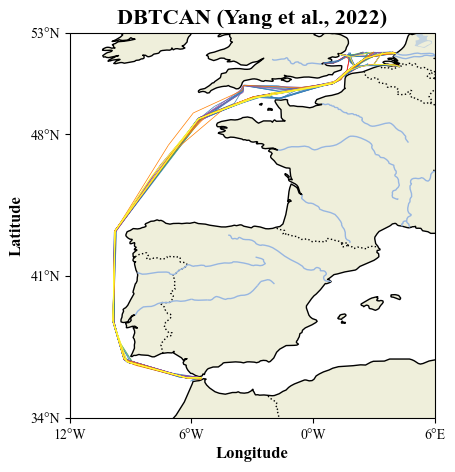

In [127]:
fig = plt.figure(figsize=(5,5))
colormp=plt.get_cmap('Set1')(range(7))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
for k in range(max(cluster_lst)+1):
    ind = [x for x, y in list(enumerate(cluster_lst)) if y == k]
    traj_list = []
    for i in range(len(ind)):
        traj_list.append(traj_collection_gs2nl_DP.trajectories[ind[i]])
    traj_set = mpd.TrajectoryCollection(traj_list)
    ax = traj_set.plot(ax = ax, color=colormp[k], linewidth =  0.5)

ax.set_extent([-12, 6, 34, 53], crs=ccrs.PlateCarree())
ax.set_xticks([-12, -6, 0, 6], crs=ccrs.PlateCarree())
ax.set_yticks([34, 41, 48, 53], crs=ccrs.PlateCarree())
# ax.stock_img()
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
# ax.add_image(imagery)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

fontlabel = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }
fonttitle = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }


lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
plt.title('DBTCAN (Yang et al., 2022)', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)

fig.savefig('tempfigs/set_3_DBTCAN.png', dpi=600)

### IDBSCAN

In [128]:
traj_collection_gs2nl_DP = STcompression(traj_collection_gs2nl, 0.1)
gdf_gs2nl_DP = traj_collection_gs2nl_DP.to_traj_gdf()

traj_list = df2list(gdf_gs2nl_DP)
traj_count = len(traj_list)
D = np.zeros((traj_count, traj_count))
# This may take a while
for i in range(traj_count):
    for j in range(i + 1, traj_count):
        distance1 = dtw(traj_list[i], traj_list[j], dist_method = haversine_dist, distance_only=True)
        D[i, j] = distance1.distance
        D[j, i] = distance1.distance

eps = find_eps(3, D)

Generating 271 trajectories in array form
The best eps value is 2086.0041763835843


In [129]:
mdl = DBSCAN(eps=eps, min_samples=2)
cluster_lst = mdl.fit_predict(D)
print(f"Trajectories are grouped into {np.max(cluster_lst) + 1} clusters")
print(f'DBI (0 means best): {metrics.davies_bouldin_score(D, cluster_lst):.3f}') 
print(f'SS (1 means better): {metrics.silhouette_score(D, cluster_lst):.3f}') 
print(f'Calinski-Harbasz Score (Larger means better): {metrics.calinski_harabasz_score(D, cluster_lst):.3f}') 

Trajectories are grouped into 5 clusters
DBI (0 means best): 1.316
SS (1 means better): -0.293
Calinski-Harbasz Score (Larger means better): 2.048


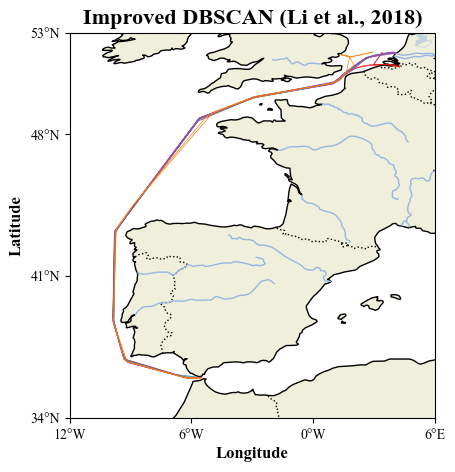

In [131]:
fig = plt.figure(figsize=(5,5))
colormp=plt.get_cmap('Set1')(range(5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
for k in range(max(cluster_lst)+1):
    ind = [x for x, y in list(enumerate(cluster_lst)) if y == k]
    traj_list = []
    for i in range(len(ind)):
        traj_list.append(traj_collection_gs2nl_DP.trajectories[ind[i]])
    traj_set = mpd.TrajectoryCollection(traj_list)
    ax = traj_set.plot(ax = ax, color=colormp[k], linewidth =  0.5)

ax.set_extent([-12, 6, 34, 53], crs=ccrs.PlateCarree())
ax.set_xticks([-12, -6, 0, 6], crs=ccrs.PlateCarree())
ax.set_yticks([34, 41, 48, 53], crs=ccrs.PlateCarree())
# ax.stock_img()
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
# ax.add_image(imagery)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

fontlabel = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }
fonttitle = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }


lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
plt.title('Improved DBSCAN (Li et al., 2018)', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)

fig.savefig('tempfigs/set_3_DBSCAN.png', dpi=600)

### Backwards trajectories

### IHDBSCAN

In [132]:
traj_collection_nl2gs = mpd.TrajectoryCollection(traj_list_nl2gs)
traj_collection_nl2gs_DP = DPcompression(traj_collection_nl2gs, 0.2)


In [133]:
# similarity measurements using DTW
gdf_nl2gs_DP = traj_collection_nl2gs_DP.to_traj_gdf()
traj_list = df2list(gdf_nl2gs_DP)
traj_count = len(traj_list)
D = np.zeros((traj_count, traj_count))
# This may take a while
for i in range(traj_count):
    for j in range(i + 1, traj_count):
        distance1 = dtw(traj_list[i], traj_list[j], dist_method = haversine_dist, distance_only=True)
        D[i, j] = distance1.distance
        D[j, i] = distance1.distance
eps = find_eps(3, D)
# eps_set = []
# for k in range(2, 50):
#     eps = find_eps(k, D)
#     eps_set.append(eps)


Generating 240 trajectories in array form
The best eps value is 463.54351382644745


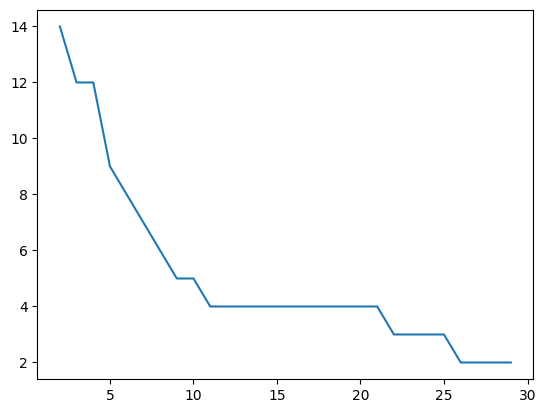

In [134]:
cluster_set = []
size_num = []
score = []
max_score = -1
for i in range(2, 30):
    size_num.append(i)
    dbscan = hdbscan.HDBSCAN(min_samples=3,min_cluster_size =i, gen_min_span_tree=True, cluster_selection_epsilon =eps)
    cluster_lst = dbscan.fit(D)
    n_cluster = np.max(dbscan.labels_) + 1
    cluster_set.append(n_cluster)
    # if metrics.silhouette_score(D, dbscan.labels_, metric="precomputed") > max_score:
    #     best_eps = eps_set[i-2]
    #     best_cluster_size = i
    #     best_score = metrics.silhouette_score(D, dbscan.labels_, metric="precomputed")
    #     max_score =  metrics.silhouette_score(D, dbscan.labels_, metric="precomputed")
    # score.append(metrics.silhouette_score(D, dbscan.labels_, metric="precomputed"))
    
# print(best_cluster_size, best_eps, best_score)
plt.plot(size_num, cluster_set)

In [135]:
dbscan = hdbscan.HDBSCAN(min_samples=2,min_cluster_size =20, gen_min_span_tree=True, cluster_selection_epsilon =eps)
cluster_lst = dbscan.fit(D)
print(f"Trajectories are grouped into {np.max(dbscan.labels_) + 1} clusters")
print(f'DBI (0 means best): {metrics.davies_bouldin_score(D, dbscan.labels_):.3f}') 
print(f'SS (1 means better): {metrics.silhouette_score(D, dbscan.labels_):.3f}') 
print(f'Calinski-Harbasz Score (Larger means better): {metrics.calinski_harabasz_score(D, dbscan.labels_):.3f}') 
label = list(dbscan.labels_)

for i in range(0, np.max(dbscan.labels_) + 1):
    print(label.count(i))

Trajectories are grouped into 4 clusters
DBI (0 means best): 1.458
SS (1 means better): 0.175
Calinski-Harbasz Score (Larger means better): 56.586
23
41
54
32


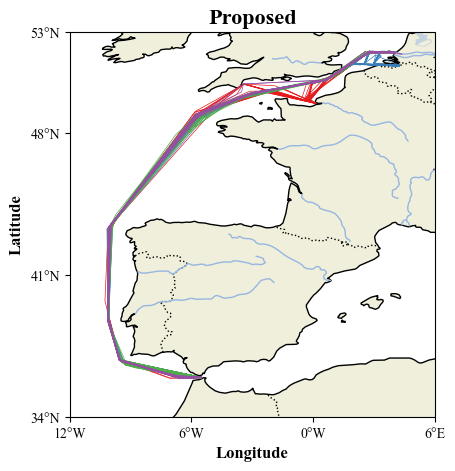

In [136]:
cluster_lst = dbscan.labels_
fig = plt.figure(figsize=(5,5))
colormp=plt.get_cmap('Set1')(range(5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
for k in range(max(dbscan.labels_)+1):
    ind = [x for x, y in list(enumerate(cluster_lst)) if y == k]
    traj_list = []
    for i in range(len(ind)):
        traj_list.append(traj_collection_nl2gs_DP.trajectories[ind[i]])
    traj_set = mpd.TrajectoryCollection(traj_list)
    ax = traj_set.plot(ax = ax, color=colormp[k], linewidth =  0.5)

ax.set_extent([-12, 6, 34, 53], crs=ccrs.PlateCarree())
ax.set_xticks([-12, -6, 0, 6], crs=ccrs.PlateCarree())
ax.set_yticks([34, 41, 48, 53], crs=ccrs.PlateCarree())
# ax.stock_img()
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
# ax.add_image(imagery)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

fontlabel = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }
fonttitle = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }


lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
plt.title('Proposed', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)

fig.savefig('tempfigs/set_3b_IHDBSCAN.png', dpi=600)

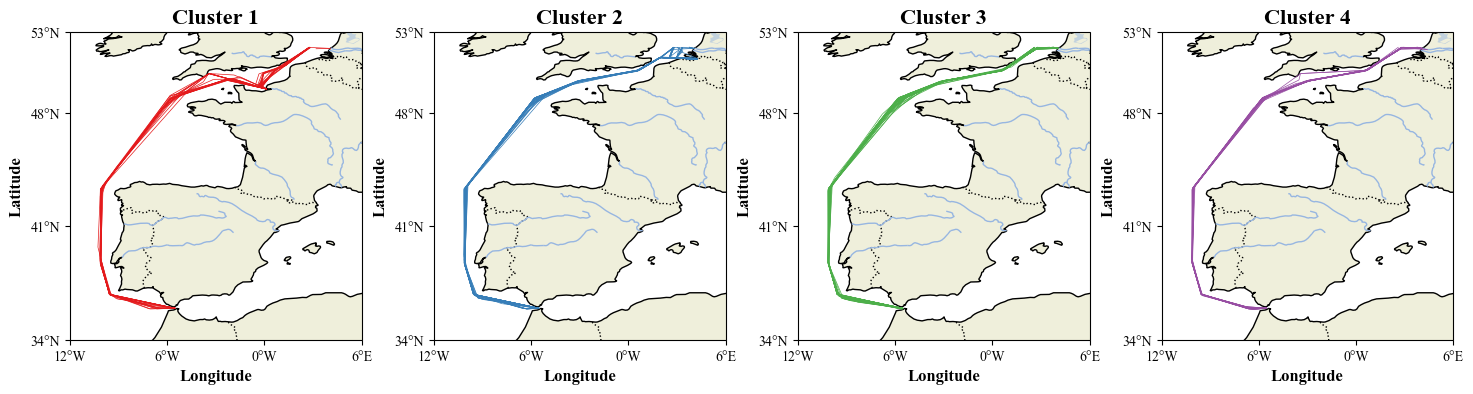

In [138]:
cluster_lst = dbscan.labels_
fig = plt.figure(figsize=(18,4))
colormp=plt.get_cmap('Set1')(range(5))
for k in range(max(dbscan.labels_)+1):
    ind = [x for x, y in list(enumerate(cluster_lst)) if y == k]
    traj_list = []
    for i in range(len(ind)):
        traj_list.append(traj_collection_nl2gs_DP.trajectories[ind[i]])
    traj_set = mpd.TrajectoryCollection(traj_list)
    ax = fig.add_subplot(1, 4, k+1, projection=ccrs.PlateCarree())
    ax = traj_set.plot(ax = ax, color=colormp[k], linewidth =  0.5)
    ax.set_extent([-12, 6, 34, 53], crs=ccrs.PlateCarree())
    # ax.stock_img()
    states_provinces = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale='50m',
            facecolor='none')
    SOURCE = 'Natural Earth'
    LICENSE = 'public domain'
    # ax.add_image(imagery)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(states_provinces, edgecolor='gray')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)

    fontlabel = {'family': 'times new roman',
            'color':  'black',
            'weight': 'bold',
            'size': 12,
            }
    fonttitle = {'family': 'times new roman',
            'color':  'black',
            'weight': 'bold',
            'size': 16,
            }

    ax.set_xticks([-12, -6, 0, 6], crs=ccrs.PlateCarree())
    ax.set_yticks([34, 41, 48, 53], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    x1_label = ax.get_xticklabels() 
    [x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
    y1_label = ax.get_yticklabels() 
    [y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
    plt.title('Cluster %d' % (k+1), fontdict=fonttitle)
    plt.xlabel('Longitude', fontdict=fontlabel)
    plt.ylabel('Latitude', fontdict=fontlabel)

    fig.savefig('tempfigs/cluster_set_3b_IHDBSCAN.png', dpi=600)

### HDBSCAN

In [142]:
traj_collection_nl2gs = mpd.TrajectoryCollection(traj_list_nl2gs)
traj_collection_nl2gs_DP = STcompression(traj_collection_nl2gs, 0.2)
# similarity measurements using DTW
gdf_nl2gs_DP = traj_collection_nl2gs_DP.to_traj_gdf()
traj_list = df2list(gdf_nl2gs_DP)
traj_count = len(traj_list)
D_h = np.zeros((traj_count, traj_count))

# This may take a while
for i in range(traj_count):
    for j in range(i + 1, traj_count):
        distance1 = hausdorff_distance(traj_list[i], traj_list[j], distance='haversine')
        D_h[i, j] = distance1
        D_h[j, i] = distance1

eps = find_eps(3, D_h)
# eps_set = []
# for k in range(2, 50):
#     eps = find_eps(k, D)
#     eps_set.append(eps)

Generating 240 trajectories in array form
The best eps value is 128.31012003207977


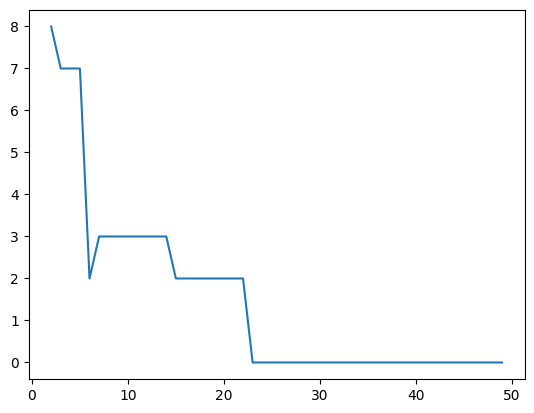

In [143]:
cluster_set = []
size_num = []
for i in range(2, 50):
    size_num.append(i)
    dbscan = hdbscan.HDBSCAN(min_samples=3, min_cluster_size =i, gen_min_span_tree=True, cluster_selection_epsilon =eps)
    cluster_lst = dbscan.fit(D_h)
    n_cluster = np.max(dbscan.labels_) + 1
    cluster_set.append(n_cluster)
    

plt.plot(size_num, cluster_set)

In [144]:
dbscan = hdbscan.HDBSCAN(min_samples=3, min_cluster_size =5,cluster_selection_epsilon =eps)
cluster_lst = dbscan.fit(D_h)
print(f"Trajectories are grouped into {np.max(dbscan.labels_) + 1} clusters")
print(f'DBI (0 means best): {metrics.davies_bouldin_score(D_h, dbscan.labels_):.3f}') 
print(f'SS (1 means better): {metrics.silhouette_score(D_h, dbscan.labels_):.3f}') 
print(f'Calinski-Harbasz Score (Larger means better): {metrics.calinski_harabasz_score(D_h, dbscan.labels_):.3f}') 

Trajectories are grouped into 7 clusters
DBI (0 means best): 1.635
SS (1 means better): 0.198
Calinski-Harbasz Score (Larger means better): 50.022


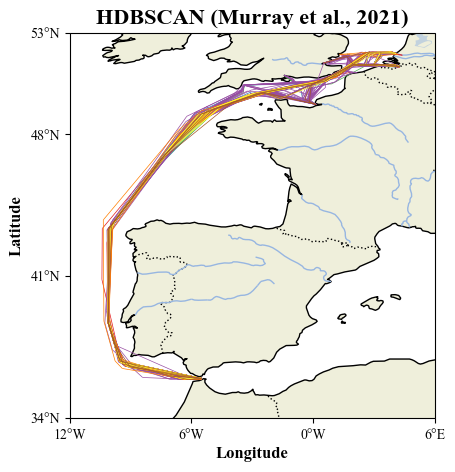

In [147]:
cluster_lst = dbscan.labels_
fig = plt.figure(figsize=(5,5))
colormp=plt.get_cmap('Set1')(range(7))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
for k in range(max(dbscan.labels_)+1):
    ind = [x for x, y in list(enumerate(cluster_lst)) if y == k]
    traj_list = []
    for i in range(len(ind)):
        traj_list.append(traj_collection_nl2gs_DP.trajectories[ind[i]])
    traj_set = mpd.TrajectoryCollection(traj_list)
    ax = traj_set.plot(ax = ax, color=colormp[k], linewidth =  0.5)

ax.set_extent([-12, 6, 34, 53], crs=ccrs.PlateCarree())
ax.set_xticks([-12, -6, 0, 6], crs=ccrs.PlateCarree())
ax.set_yticks([34, 41, 48, 53], crs=ccrs.PlateCarree())
# ax.stock_img()
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
# ax.add_image(imagery)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

fontlabel = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }
fonttitle = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }


lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
plt.title('HDBSCAN (Murray et al., 2021)', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)

fig.savefig('tempfigs/set_3b_HDBSCAN.png', dpi=600)

### DBTCAN

In [148]:
traj_collection_nl2gs = mpd.TrajectoryCollection(traj_list_nl2gs)
traj_collection_nl2gs_DP = STcompression(traj_collection_nl2gs, 0.3)
# similarity measurements using DTW
gdf_nl2gs_DP = traj_collection_nl2gs_DP.to_traj_gdf()
traj_list = df2list(gdf_nl2gs_DP)
traj_count = len(traj_list)
D_h = np.zeros((traj_count, traj_count))

# This may take a while
for i in range(traj_count):
    for j in range(i + 1, traj_count):
        distance1 = hausdorff_distance(traj_list[i], traj_list[j], distance='haversine')
        D_h[i, j] = distance1
        D_h[j, i] = distance1

eps_set = []
for i in range(2, 20):
    eps_set.append(find_eps(i, D_h))

eps_set

Generating 240 trajectories in array form
The best eps value is 52.36271617322875
The best eps value is 78.88990569972013
The best eps value is 75.57308242869374
The best eps value is 105.96316533909751
The best eps value is 122.61681790334141
The best eps value is 130.77786553217123
The best eps value is 149.08960340797128
The best eps value is 169.8970648460798
The best eps value is 182.10023493037176
The best eps value is 187.89458639669104
The best eps value is 212.36987908956883
The best eps value is 201.77850673156175
The best eps value is 193.4380403857033
The best eps value is 208.5400326552014
The best eps value is 215.3937549209724
The best eps value is 214.18592188478382
The best eps value is 220.40603075655835
The best eps value is 241.26072744133393


[52.36271617322875,
 78.88990569972013,
 75.57308242869374,
 105.96316533909751,
 122.61681790334141,
 130.77786553217123,
 149.08960340797128,
 169.8970648460798,
 182.10023493037176,
 187.89458639669104,
 212.36987908956883,
 201.77850673156175,
 193.4380403857033,
 208.5400326552014,
 215.3937549209724,
 214.18592188478382,
 220.40603075655835,
 241.26072744133393]

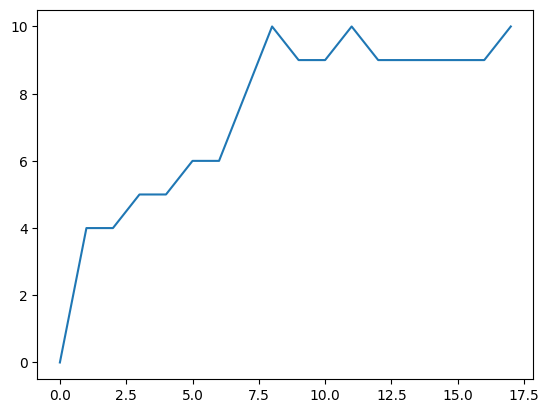

In [149]:
cluster_set = []
size_num = []
for i in range(0, len(eps_set)):
    size_num.append(i)
    mdl = DBSCAN(eps=eps_set[i], min_samples=4)
    cluster_lst = mdl.fit_predict(D_h)
    n_cluster = np.max(cluster_lst) + 1
    cluster_set.append(n_cluster)
    

plt.plot(size_num, cluster_set)

In [150]:
mdl = DBSCAN(eps=eps_set[8], min_samples=3)
cluster_lst = mdl.fit_predict(D_h)
print(f"Trajectories are grouped into {np.max(cluster_lst) + 1} clusters")
print(f'DBI (0 means best): {metrics.davies_bouldin_score(D_h, cluster_lst):.3f}') 
print(f'SS (1 means better): {metrics.silhouette_score(D_h, cluster_lst):.3f}') 
print(f'Calinski-Harbasz Score (Larger means better): {metrics.calinski_harabasz_score(D_h, cluster_lst):.3f}') 

Trajectories are grouped into 10 clusters
DBI (0 means best): 1.207
SS (1 means better): -0.107
Calinski-Harbasz Score (Larger means better): 9.022


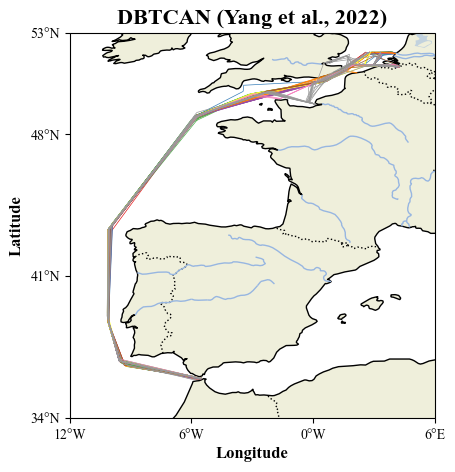

In [151]:

fig = plt.figure(figsize=(5,5))
colormp=plt.get_cmap('Set1')(range(10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
for k in range(max(cluster_lst)+1):
    ind = [x for x, y in list(enumerate(cluster_lst)) if y == k]
    traj_list = []
    for i in range(len(ind)):
        traj_list.append(traj_collection_nl2gs_DP.trajectories[ind[i]])
    traj_set = mpd.TrajectoryCollection(traj_list)
    ax = traj_set.plot(ax = ax, color=colormp[k], linewidth =  0.5)

ax.set_extent([-12, 6, 34, 53], crs=ccrs.PlateCarree())
ax.set_xticks([-12, -6, 0, 6], crs=ccrs.PlateCarree())
ax.set_yticks([34, 41, 48, 53], crs=ccrs.PlateCarree())
# ax.stock_img()
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
# ax.add_image(imagery)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

fontlabel = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }
fonttitle = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }


lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
plt.title('DBTCAN (Yang et al., 2022)', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)

fig.savefig('tempfigs/set_3b_DBTCAN.png', dpi=600)

### IDBSCAN

In [152]:

traj_collection_nl2gs_DP = STcompression(traj_collection_nl2gs, 0.3)
# similarity measurements using DTW
gdf_nl2gs_DP = traj_collection_nl2gs_DP.to_traj_gdf()
traj_list = df2list(gdf_nl2gs_DP)
traj_count = len(traj_list)
D = np.zeros((traj_count, traj_count))
# This may take a while
for i in range(traj_count):
    for j in range(i + 1, traj_count):
        distance1 = dtw(traj_list[i], traj_list[j], dist_method = haversine_dist, distance_only=True)
        D[i, j] = distance1.distance
        D[j, i] = distance1.distance

eps = find_eps(3, D)

Generating 240 trajectories in array form
The best eps value is 430.46386689616736


In [153]:
mdl = DBSCAN(eps=eps, min_samples=3)
cluster_lst = mdl.fit_predict(D_h)
print(f"Trajectories are grouped into {np.max(cluster_lst) + 1} clusters")
print(f'DBI (0 means best): {metrics.davies_bouldin_score(D, cluster_lst):.3f}') 
print(f'SS (1 means better): {metrics.silhouette_score(D, cluster_lst):.3f}') 
print(f'Calinski-Harbasz Score (Larger means better): {metrics.calinski_harabasz_score(D, cluster_lst):.3f}') 

Trajectories are grouped into 7 clusters
DBI (0 means best): 3.193
SS (1 means better): -0.203
Calinski-Harbasz Score (Larger means better): 8.078


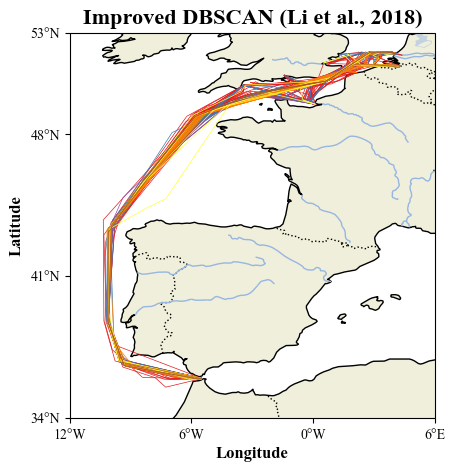

In [154]:

fig = plt.figure(figsize=(5,5))
colormp=plt.get_cmap('Set1')(range(10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
for k in range(max(cluster_lst)+1):
    ind = [x for x, y in list(enumerate(cluster_lst)) if y == k]
    traj_list = []
    for i in range(len(ind)):
        traj_list.append(traj_collection_nl2gs_DP.trajectories[ind[i]])
    traj_set = mpd.TrajectoryCollection(traj_list)
    ax = traj_set.plot(ax = ax, color=colormp[k], linewidth =  0.5)

ax.set_extent([-12, 6, 34, 53], crs=ccrs.PlateCarree())
ax.set_xticks([-12, -6, 0, 6], crs=ccrs.PlateCarree())
ax.set_yticks([34, 41, 48, 53], crs=ccrs.PlateCarree())
# ax.stock_img()
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
# ax.add_image(imagery)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

fontlabel = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }
fonttitle = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }


lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
plt.title('Improved DBSCAN (Li et al., 2018)', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)

fig.savefig('tempfigs/set_3b_DBSCAN.png', dpi=600)

## Traffic flow

In [4]:

from OD_cluster import *
traj_DP = DPcompression(traj, 0.6)


In [5]:
def min_max_normalization(value):
    """归一化，也称离差标准化
    公式：(原始值-最小值)/(最大值-最小值)
    :return 值域[0,1]
    """
    new_value = (value - value.min()) / (value.max() - value.min())
    return new_value

In [32]:
aggregator = OD_cluster(traj_DP, max_distance=12, min_distance=5,min_stop_duration=timedelta(hours=12)) # original 13 5
flows = aggregator.get_flows_gdf()
clusters = aggregator.return_clusters_gdf()
dosize = clusters.n*3
weight = min_max_normalization(flows.weight)
# df_weight = pd.DataFrame(weight) + 1
# pd.merge(flows, weight,how='right')
flows['weight'] = 20*(weight+0.1)

Extracting significant points ...


In [31]:
points = clusters.geometry

xs = [point.x for point in points]
ys = [point.y for point in points]
df = pd.DataFrame(xs, ys)
df.to_csv('local_node_set_3.csv')

In [33]:
flows.hvplot(title='Traffic flows',fontsize = 16, geo=True, hover_cols='weight', line_width='weight', alpha=0.3, color='b', tiles='CartoEco', frame_height=1200, frame_width=700) \
    * clusters.hvplot(geo=True, c = 'n', size=dosize, tiles='CartoLight', cmap='spring') 

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Path.I   :Path   [Longitude,Latitude]   (weight)
   .WMTS.II  :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (n,_size)